# **MDI230 - PROJET EPIDEMIOLOGIE** 
GUEZ ELIOT

----------------

1. Contexte
--- 
Il s'agit de voir les différences entre le modèle markovien et le modèle déterministe de la diffusion d'une épidémie. Vous devez rendre un fichier unique soit en pdf, soit en ipynb.

2. Devoir
--- 

A. Ecrire un code :
 - qui résout et affiche le système déterministe SIR, prenant en entrée les paramètres beta et gamma (voir poly)
 - qui simule l'évolution du processus de Markov pour une population de N individus avec les mêmes paramètres beta et gamma

B. Trouver les couples (beta, gamma) où
 - tout le monde est retiré sur le long terme
 - il y a une partie de la population qui reste suceptible et une autre qui est retirée

C. Illustrer sur des graphiques la convergence du processus de Markov renormalisé vers la solution du système déterministe

D. Question ouverte avec différentes réponses possibles : A partir des données de Santé Publique France, notamment le fichier "donnees_hospitalieres_nouveaux_covid19..." qui comportent 4 colonnes : les hospitalisations (hos), les admissions en réanimation (rea), les décès (dc) et les retournés à la maison (rad) pour chaque jour et pour chaque département, comment feriez-vous pour estimer gamma et beta sur un département donné ?



### **Modèle SIR déterministe**
---

La population est de taille N+1. Soit S(t) les susceptibles, I(t) les infectieux et R(t) les retirés. On a l'équation toujours vérifiable :  
$S(t) + I(t) + R(t) = N+1\\$ 
et à l'instant initiale, il n'y a qu'un seul infecté :  
$S(t) = N, I(t) =1, R(t) =0$

Dans cette modélisation, chaque infecté rencontre un autre individu aux instants d'un processus de Poisson d'intensité $\beta$. La durée d'une infection suit une loi exponentielle de parametre $\gamma$.

On doit résoudre le système d'équation suivant : 

\begin{cases}
s′(t) = −\beta s(t)i(t)\\
i′(t) = \beta s(t)i(t) − \gamma i(t)\\
r′(t) = \gamma i(t)
\end{cases}
avec les contraintes suivantes :  $s(t) \geq 0, i(t) \geq 0, r(t) \geq 0 $ et les conditions initiales suivantes  : $s(t) \geq 0, i(t) > 0, r(t) \geq 0$




**Import et Initialisation**

In [247]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
import pandas as pd

In [248]:
N = 1000
s0 = 999
i0 = 1
r0 = 0
beta = 2
gamma = 1 

#### **Question 1**
---

In [249]:
def model_SIR(y, t, N, beta, gamma):
    s, i, r = y
    dsdt = -beta * s * i / N
    didt = beta * s * i / N - gamma * i
    drdt = gamma * i
    return [dsdt, didt, drdt]

In [250]:
t = np.linspace(0, 100, 1000)
y0 = [s0, i0, r0]
sol = odeint(model_SIR, y0, t, args=(N, beta, gamma))
s,i,r = sol.T
print(round(s[-1]), round(i[-1]), round(r[-1]))

203 0 797


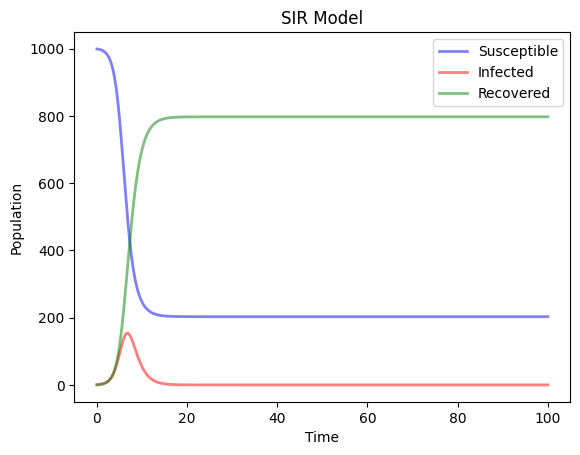

In [251]:
fig = plt.figure()
plt.plot(t, s, 'b', alpha =0.5, lw=2,  label='Susceptible')
plt.plot(t, i, 'r',alpha =0.5, lw=2, label='Infected')
plt.plot(t, r, 'g',alpha =0.5, lw=2,  label='Recovered')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('SIR Model')
plt.show()

Pour construire un modèle de markov, on doit changer la signification de béta qui doit valoir maintenant le taux de rencontre avec les susceptible, infectés, ou les retirés. De cette manière, quand la durée de l'infection est distribué selon une exponentielle de moyenne $\frac 1 \gamma$, le processus X= (S,I,R) est une chaine de Markov qui admet les transitions :
1. $(s,i,r) \rightarrow (s-1, i+1, r) \quad \text{avec un taux } \beta N^{-1} is1_{s >0} $
2. $(s,i,r) \rightarrow (s, i-1, r+1) \quad \text{avec un taux } \gamma i 1_{i>0} $

En effet, le taux d'infection est donnée par $\beta i$ et chaque infecté à une probabilité de $\frac s N$ de rencontrer une personne susceptible, d'où cette formule de transition. 
Chaque personne a une probabilité $\gamma$ de guérir (ou mourir) d'où la probabilité de transition de l'état i à r. 

In [252]:
def new_state(state, beta, gamma, N):
    s,i,r = state
    transitions = np.array([beta * s * i / N,  gamma * i ])
    lambda_tot = np.sum(transitions)

    if lambda_tot == 0: return state, lambda_tot

    transitions /= lambda_tot
    transition_index = np.random.choice([0, 1], p=transitions)

    new_state = np.array(state)
    if transition_index == 0:  # S->I
        new_state[0] -= 1
        new_state[1] += 1
    elif transition_index == 1:  # I->R
        new_state[1] -= 1
        new_state[2] += 1

    return new_state, lambda_tot

def simulate_sir(initial_state, beta, gamma, N, time=100):
    state = np.array(initial_state)
    states = [state.copy()]
    t = 0
    T = [t]
    while t < time:
        state, lambd = new_state(state, beta, gamma, N)
        if lambd == 0: break
        t += np.random.exponential(1/lambd)
        states.append(state.copy())
        T.append(t)
    print(T[-1])
    return np.array(states), np.array(T)

In [258]:
initial_state = [999, 1, 0]
time = 1000
states, T = simulate_sir(initial_state, beta, gamma, N, time)

19.098330868930706


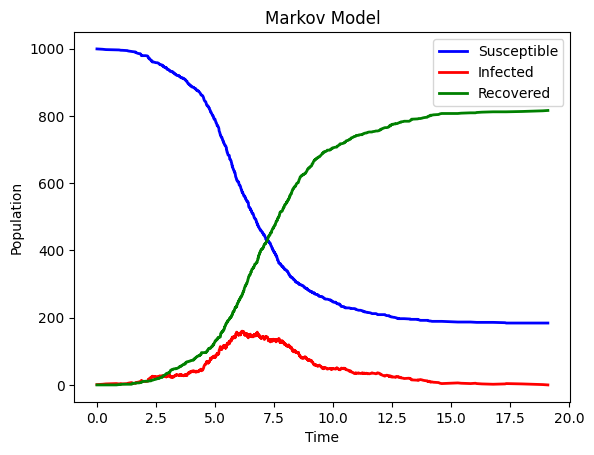

In [259]:
fig = plt.figure()
plt.plot(T, states[:, 0], 'b', lw=2, label='Susceptible')
plt.plot(T, states[:, 1], 'r', lw=2, label='Infected')
plt.plot(T, states[:, 2], 'g', lw=2, label='Recovered')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Markov Model')
plt.show()

Let's compare the two models on a plot 

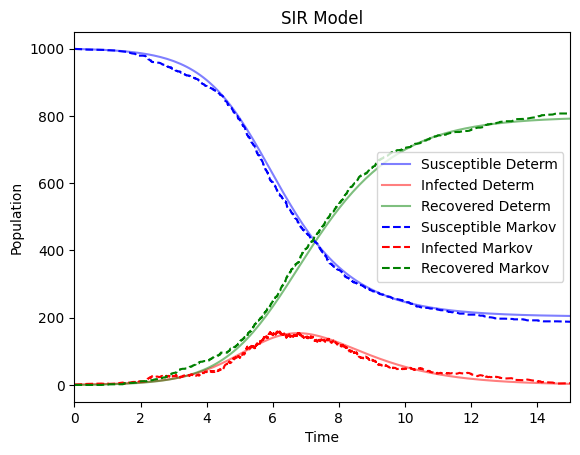

In [260]:
fig = plt.figure()
plt.plot(t, s, 'b', alpha =0.5,  label='Susceptible Determ')
plt.plot(t, i, 'r',alpha =0.5,  label='Infected Determ')
plt.plot(t, r, 'g',alpha =0.5,   label='Recovered Determ')
plt.plot(T, states[:, 0], 'b--',  label='Susceptible Markov')
plt.plot(T, states[:, 1], 'r--',  label='Infected Markov')
plt.plot(T, states[:, 2], 'g--', label='Recovered Markov')
plt.xlim(0, 15)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('SIR Model')
plt.show()

Les modèles sont assez similaires mais la nature probabiliste du modèle markovien peut parfois créer des grosses différences. 

#### **Question 2**
---
1. Trouver les valeurs $\beta$ et $\gamma$ où tout le monde est retiré sur le long term il faut augmenter beta pour que l'infection se propage très vite ou diminuer gamma pour que les infectés contaminent plus longtemps. 
2. Pour trouver des valeurs telles qu'il y ait à la fin des gens susceptibles et des gens infectés, il faut que l'infection ne se propage pas. Donc il faut prendre un petit $\beta $.

1.8397660966239526
0.9091001657242312
0.6710211176087503
23.48108942104012
7.285890354657835
7.332229835732476
9.904093886205308
14.417979078138307
5.350883019140606
5.301230086160986
7.672395109592069
15.180326233262026
4.122478017094665
4.474347088856719
7.158008756524922
15.855348396488953


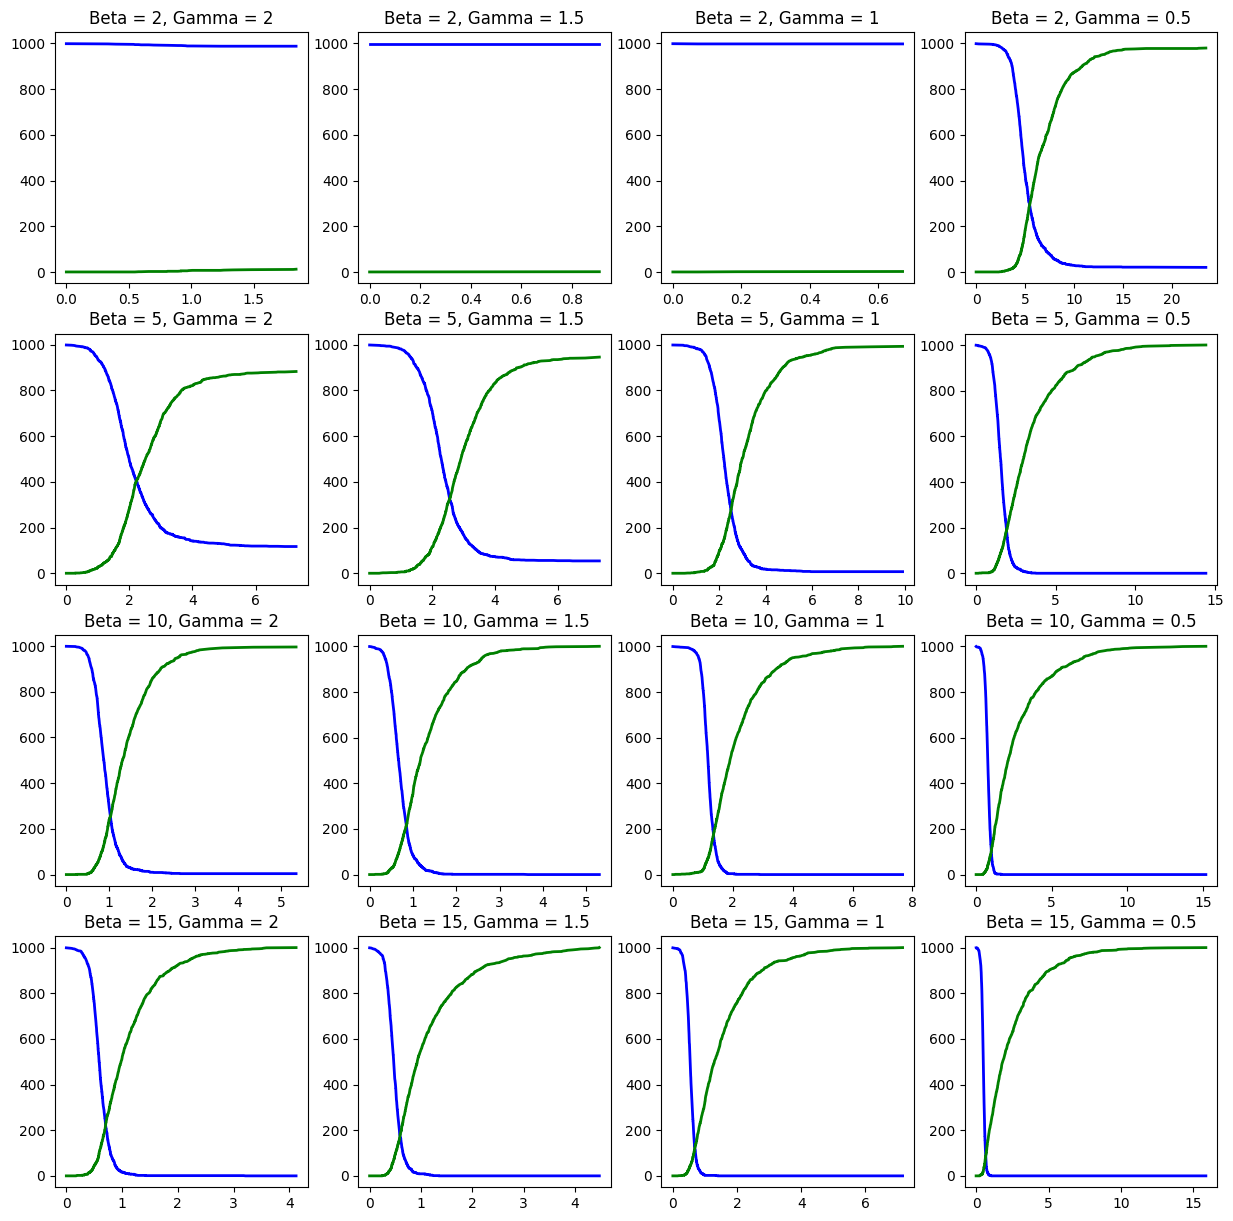

In [267]:
init = np.array([N-1, 1, 0])
beta = [2,5,10,15]
gamma = [2,1.5,1,0.5]
fig,axs = plt.subplots(4,4, figsize=(15,15))

d = {
    'beta' : [],
    'gamma' : [],
    'susceptible' : [],
    'recovered' : []
}
for i in range(4):
    for j in range(4):
        states, T = simulate_sir(init, beta[i], gamma[j], N, time)
        s = states[:, 0]
        r = states[:, 2]
        d['gamma'].append(gamma[j])
        d['beta'].append(beta[i])
        d['susceptible'].append(s[-1])
        d['recovered'].append(r[-1])
        axs[i,j].plot(T, states[:, 0], 'b', lw=2, label='Susceptible')
        axs[i,j].plot(T, states[:, 2], 'g', lw=2, label='Recovered')
        axs[i,j].set_title(f'Beta = {beta[i]}, Gamma = {gamma[j]}')

In [268]:
df = pd.DataFrame(d)
df

,beta,gamma,susceptible,recovered
0,2,2.0,988,12
1,2,1.5,999,1
2,2,1.0,998,2
3,2,0.5,20,980
4,5,2.0,117,883
5,5,1.5,54,946
6,5,1.0,7,993
7,5,0.5,0,1000
8,10,2.0,4,996
9,10,1.5,0,1000


On observe bien que pour beta grand et gamma petit on tend vite vers une solution où tout le monde est retiré (numériquement $\beta \geq 5$ et $\gamma \leq 1$).
Tout le monde n'est pas retiré pour $\beta \leq 2$ 


#### **Question 3**
---
Illustrer sur des graphiques la convergence du processus de Markov renormalisé vers la solution du système déterministe

In [273]:
#compare model for different pop 
def compare(N, beta, gamma, T):
    #model 1
    t = np.linspace(0, T, 1000)
    y0 = [N-10,  10, 0]
    sol = odeint(model_SIR, y0, t, args=(N, beta, gamma))
    s,i,r = sol.T
    #model 2
    initial_state = [N-10, 10, 0]
    time = T
    states, T = simulate_sir(initial_state, beta, gamma, N, time)

    # plot 
    fig = plt.figure()
    plt.plot(t, s, 'b', alpha =0.5,  label='Susceptible Determ')
    plt.plot(t, i, 'r',alpha =0.5,  label='Infected Determ')
    plt.plot(t, r, 'g',alpha =0.5,   label='Recovered Determ')
    plt.plot(T, states[:, 0], 'b--',  label='Susceptible Markov')
    plt.plot(T, states[:, 1], 'r--',  label='Infected Markov')
    plt.plot(T, states[:, 2], 'g--', label='Recovered Markov')
    plt.xlim(0, 15)
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title(f'Comparison for population {N}')
    plt.show()
        

7.625934399652962


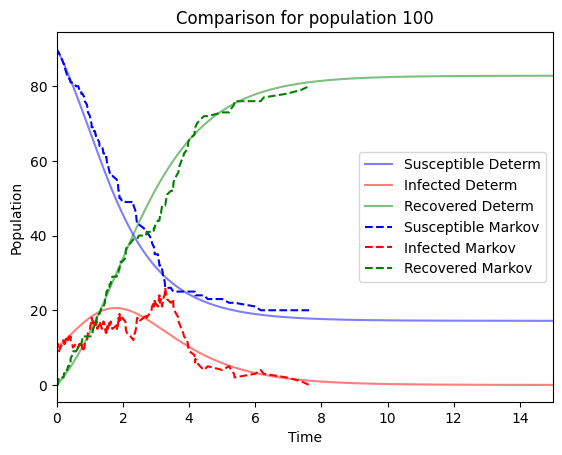

8.627554284324862


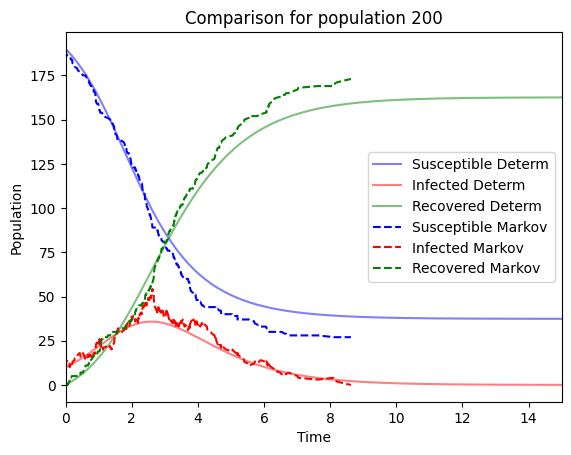

14.287663299086391


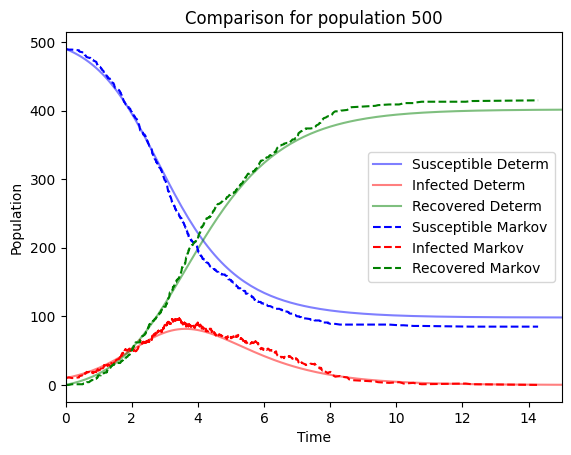

13.800188885316032


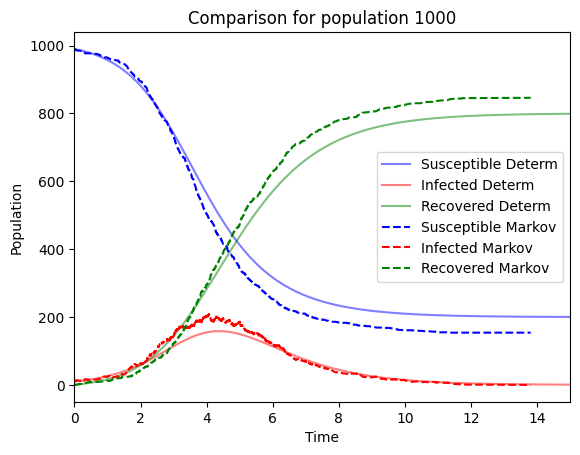

22.421588891290302


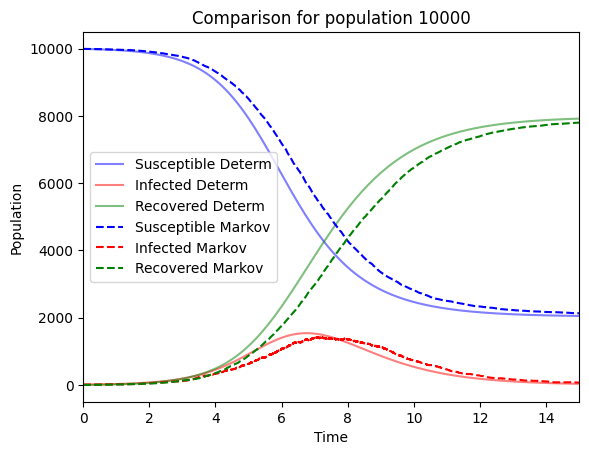

24.98297095469377


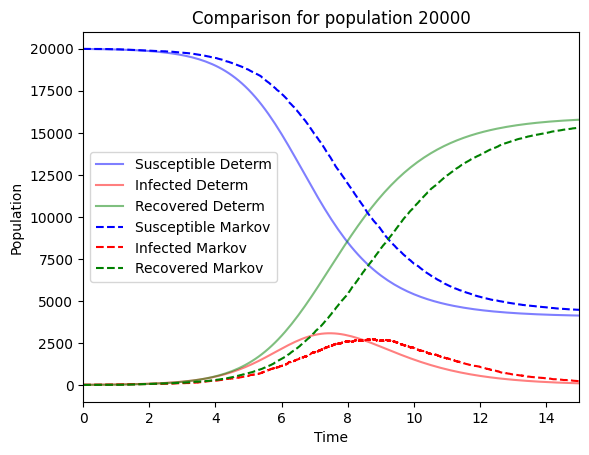

26.57739570100664


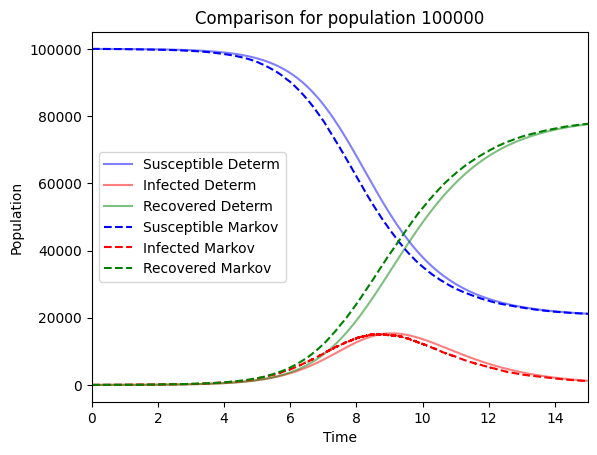

In [277]:
N = [100,200, 500, 1000, 10000, 20000, 100000]
beta = 2
gamma = 1
T = 100
for n in N:
    compare(n, beta, gamma, T)

2.72812675723309
9.090323757706713
11.716647520192424
10.771858548272048
10.600788270027966
16.513790340307526
11.078234672073307
12.216682360994076
12.89914560883396
12.880203204280873
15.1525471159303
15.18569471876356
16.458420878204425
16.768755622688687
15.62249744930423
15.967973721141487
16.145553035855336
14.521165749477637
14.030608449948835
15.705527344170143


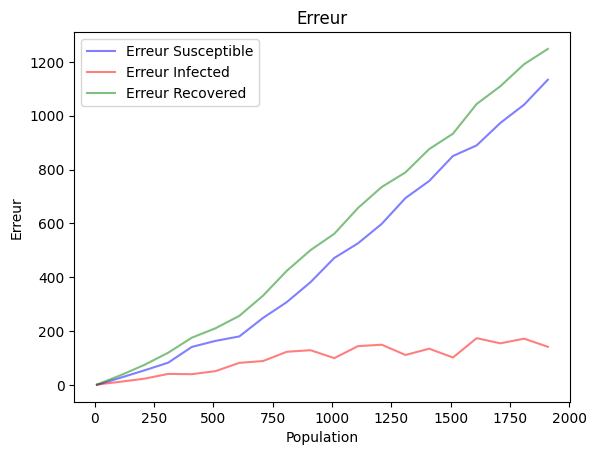

In [291]:
# beta =2 
# gamma = 1
# erreur_S = []
# erreur_I = []
# erreur_R = []
# T = 100
# Ns = np.arange(10,2000,100)
# for N in Ns:
#     t = np.linspace(0, T, 1000)
#     y0 = [N-10,  10, 0]
#     sol = odeint(model_SIR, y0, t, args=(N, beta, gamma))
#     s,i,r = sol.T
#     #model 2
#     initial_state = [N-10, 10, 0]
#     time = T
#     states, times = simulate_sir(initial_state, beta, gamma, N, time)
#     l = len(states)
#     if l <= 1000: 
#         erreur_S.append(np.mean(np.abs(s[:l]-states[:,0])))
#         erreur_I.append(np.mean(np.abs(i[:l]-states[:,1])))
#         erreur_R.append(np.mean(np.abs(r[:l]-states[:,2])))
#     else:
#         erreur_S.append(np.mean(np.abs(s-states[:1000,0])))
#         erreur_I.append(np.mean(np.abs(i-states[:1000,1])))
#         erreur_R.append(np.mean(np.abs(r-states[:1000,2])))

    
# fig = plt.figure()
# plt.plot(Ns, erreur_S, 'b', alpha =0.5,  label='Erreur Susceptible')
# plt.plot(Ns, erreur_I, 'r',alpha =0.5,  label='Erreur Infected')
# plt.plot(Ns, erreur_R, 'g',alpha =0.5,   label='Erreur Recovered')
# plt.legend(loc='best')
# plt.xlabel('Population')
# plt.ylabel('Erreur')
# plt.title('Erreur')
# plt.show()

On remarque bien que lorsque le nombre d'individu augmente, la corélation entre les courbes s'améliore ce qui illustre en effet la convergence.

#### **Question 4**
---
A partir des données de Santé Publique France, notamment le fichier "donnees_hospitalieres_nouveaux_covid19..." qui comportent 4 colonnes : les hospitalisations (hos), les admissions en réanimation (rea), les décès (dc) et les retournés à la maison (rad) pour chaque jour et pour chaque département, comment feriez-vous pour estimer gamma et beta sur un département donné ?


In [278]:
data = pd.read_csv('donnees-covid.csv', sep=';')
data

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
0,1,2020-03-19,1,0,0,0
1,1,2020-03-20,0,0,0,1
2,1,2020-03-21,3,0,0,0
3,1,2020-03-22,3,1,0,1
4,1,2020-03-23,14,1,0,5
...,...,...,...,...,...,...
26659,976,2020-12-03,0,0,0,1
26660,976,2020-12-04,0,0,0,0
26661,976,2020-12-05,0,1,0,3
26662,976,2020-12-06,0,0,0,0


On peut supposer que le nombre d'infectés I est égale à incid_hosp + incid_rea et que le nombre de recover est incid_dc + incid_rad

On peut donc trouver les valeurs de $\beta$ et $\gamma$ grace aux équations différentielles.

En effet : 
$r'(t) = \gamma i(t)$ d'où 
$$
\frac {\sum_t \frac {R'(t)} {I(t)} } T
$$

et on a 
$$
s′(t) = −\beta s(t)i(t)
$$
d'où 
$$
\beta = - \frac  {\sum_t \frac {S'(t)} {S(t) I(t)}} T
$$

On va essayer d'estimer sur le département de Paris (75)

In [293]:
data['jour'] = pd.to_datetime(data['jour'])

# get paris data
data = data[data['dep'] == '75'].copy()

data.loc[:, 'I'] = data['incid_hosp'] + data['incid_rea']
data.loc[:, 'R'] = data['incid_dc'] + data['incid_rad']

data.sort_values('jour', inplace=True)

data.loc[:, 'dI'] = data['I'].diff().fillna(0)
data.loc[:, 'dR'] = data['R'].diff().fillna(0)

data.loc[:, 'gamma_est'] = data['dR'] / data['I'].replace(0, np.nan)
gamma = data['gamma_est'].mean(skipna=True)

N = 2133111

data.loc[:, 'S'] = N - data['I'].cumsum()

data.loc[:, 'beta_est'] = -data['dI'] / (data['S'] * data['I']).replace(0, np.nan)
beta = data['beta_est'].mean(skipna=True)

print(f"Estimation de gamma pour le département 75: {gamma}")
print(f"Estimation de beta pour le département 75: {beta}")

Estimation de gamma pour le département 75: -0.35768931189566383
Estimation de beta pour le département 75: 1.0763154358413027e-07


C:\Users\eliot\AppData\Local\Temp\ipykernel_15676\3094039834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['jour'] = pd.to_datetime(data['jour'])


les valeurs semblent très fausses ici puisque $\beta$ semble être généralement entre 0.1 et 0.3 tandis que $\gamma$ est à peu près de 0.1 par jour